# Fruit Multi-Classifier 

We will train a fruit classifier using multi-label classification. It is a part of further research part of [fastbook](https://github.com/fastai/fastbook) chapter6. Instead of creating a bear classifier, we will classify three fruits: apple, orange, and pears. 

![Image of an apple and a pear](apple_and_pear.jpg "Apple and Pear")

Why fruits? While I was trying to find images on duckduckgo for teddy bear and grizzly bear together, I could not find them. On the other hand, I could find images with apple and pear easilly. I was also able to find many images with all three of them. Therefore, I chose fruits.

## Import libraries and download data

We start importing fastai library and other functions we will use to search and download images.

In [ ]:
from fastai.vision.all import *
from fastdownload import download_url

from duckduckgo_search import ddg_images

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

We can define a function, `search_show_image`, which searches the term, download, and shows the image. This way, we can check whether we're getting the right images.

In [ ]:
def search_show_image(term, dest=None):
    """Search, download, and show the image from the url."""
    url = search_images(term, max_images=1)[0]
    if not dest: dest = term + '.jpg'
    download_url(url, dest, show_progress=False)
    im = Image.open(dest)
    return im.to_thumb(256, 256)

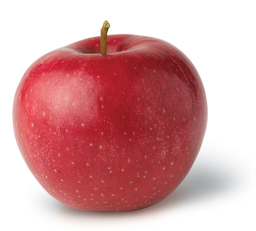

In [ ]:
search_show_image('apple')

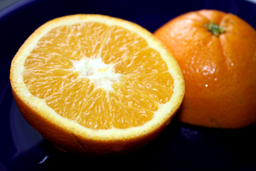

In [ ]:
search_show_image('orange')

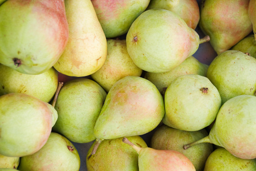

In [ ]:
search_show_image('pear')

We can have multiple categories in an image. We can either have two categories or all three! 

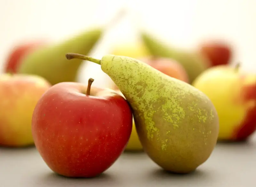

In [ ]:
search_show_image('apple and pear')

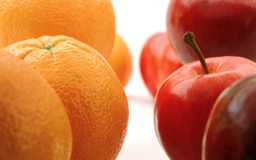

In [ ]:
search_show_image('apple and orange')

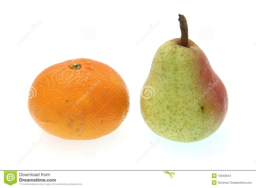

In [ ]:
search_show_image('pear and orange')

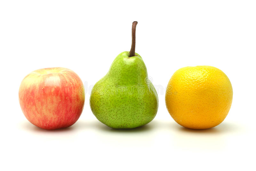

In [ ]:
search_show_image('apple and pear and orange')

Another challenge is predicting "no fruit." We can search random images and use that for this purpose. 

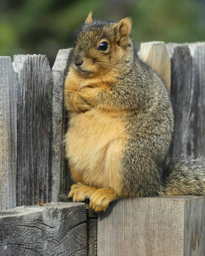

In [ ]:
search_show_image('random images')

Now we start downloading images. We search all possible combinations of labels.

In [ ]:
path = Path('fruit_or_not')

In [ ]:
searches = ('apple','pear', 'orange', 
            'apple and pear', 'apple and orange', 'pear and orange', 
            'apple and pear and orange',
            'random images')

from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Check and get rid of failed images.

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

17

In [ ]:
path.ls()

(#8) [Path('fruit_or_not/pear'),Path('fruit_or_not/apple and orange'),Path('fruit_or_not/apple and pear and orange'),Path('fruit_or_not/apple'),Path('fruit_or_not/orange'),Path('fruit_or_not/apple and pear'),Path('fruit_or_not/random images'),Path('fruit_or_not/pear and orange')]

## DataBlock

Since we have data, we start building a datablock. Since this is a multi-label classification, we use `MultiCategoryBlock`, instead of `CategoryBlock`. Another different thing is `get_y`. We can use `parent_label` for the labels. We will get `apple`, `pear`, and `orange`. But we also have problems. We will also get `apple and pear and orange`, which does not mean all three images for the model. So, we use a list of categories for the label. For instance, we will use `['apple']` for apple, `['apple, 'pear', 'orange']` for all three. 

So, we define a function, `get_y`, which splits the names. We could also have used lambda function here. However, if we want to export our learner and load it later for inference, we have to define a function this way.

In [ ]:
def get_y(path):
    return parent_label(path).split(' and ')

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=get_y,
    item_tfms=[Resize(192, method='squish')]
)

In [ ]:
path.ls()

(#8) [Path('fruit_or_not/pear'),Path('fruit_or_not/apple and orange'),Path('fruit_or_not/apple and pear and orange'),Path('fruit_or_not/apple'),Path('fruit_or_not/orange'),Path('fruit_or_not/apple and pear'),Path('fruit_or_not/random images'),Path('fruit_or_not/pear and orange')]

By using `dblock.summary(path)`, we can see exactly what's going on behind the scenes. For y, we got `[random images]`, which was turned into `TensorMultiCategory([3])`, and also into `TensorMultiCategory([0., 0., 0., 1.])` with `OneHotEncode`.

In [ ]:
dblock.summary(path)

Setting-up type transforms pipelines
Found 1620 items
2 datasets of sizes 1296,324
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_y -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: PILBase.create
    starting from
      fruit_or_not/random images/a65bc8f7-8849-4207-ac8c-4a54bf119395.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=400x300
  Pipeline: get_y -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}
    starting from
      fruit_or_not/random images/a65bc8f7-8849-4207-ac8c-4a54bf119395.jpg
    applying get_y gives
      [random images]
    applying MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorMultiCategory([3])
    applying OneHotEncode -- {'c': None} gives
      TensorMultiCategory([0., 0., 0., 1.])

Final sample: (PILImage mode=RGB size=400x300, TensorMultiCategory([0., 0., 0.

With `dblock`, we create `datasets`. Before we move onto the next step, we take a look at x and y to actually check they look okay. We also check vocab.

In [ ]:
dsets = dblock.datasets(path)

In [ ]:
len(dsets)

1620

In [ ]:
x, y = dsets[550]

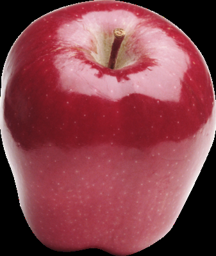

In [ ]:
x.to_thumb(256, 256)

In [ ]:
y

TensorMultiCategory([1., 0., 0., 0.])

In [ ]:
dsets.vocab

['apple', 'orange', 'pear', 'random images']

Everything looks good, so we move on to `dataloaders`. We can use `show_batch` to take a look at images and labels respectively.

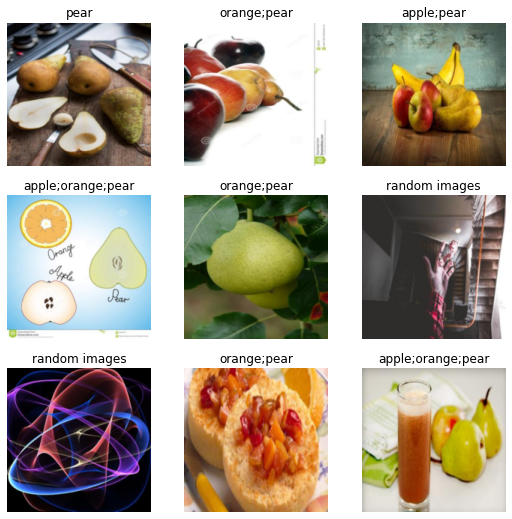

In [ ]:
dls = dblock.dataloaders(path)
dls.show_batch()

Some images may not be right since we downloaded them from a search engine. The best way to find out whether it will work or not is just start training and see how it performs!

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0010000000474974513)

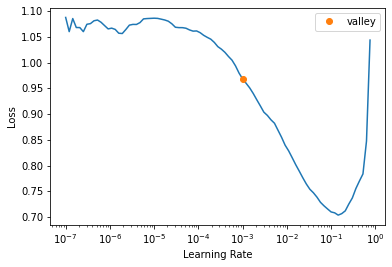

In [ ]:
learn = vision_learner(dls, resnet18, metrics=accuracy_multi)
learn.lr_find()

In [ ]:
learn.fine_tune(5, 0.01)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.661995,0.422173,0.854167,00:07


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.313802,0.438793,0.861883,00:08
1,0.226740,0.426513,0.868056,00:08
2,0.166382,0.364287,0.891975,00:08
3,0.119406,0.320120,0.905093,00:08
4,0.086154,0.311800,0.903549,00:08


We can optionally try to find the optimal value for `thresh` keyword, but it's good where we are.

In [ ]:
preds, targs = learn.get_preds()

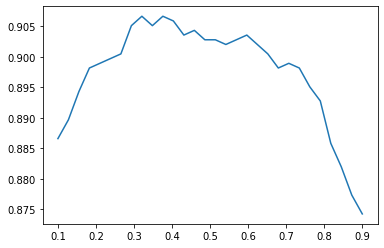

In [ ]:
xs = torch.linspace(0.1, .9, 30)
ys = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, ys);

Let's find out what our model had trouble with.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix()

,target,predicted,probabilities,loss
0,random images,apple,"TensorBase([0.9999, 0.0204, 0.0098, 0.0011])",3.993837356567383
1,apple,random images,"TensorBase([2.5680e-03, 1.7837e-03, 4.3446e-04, 9.9994e-01])",3.9354634284973145
2,apple,orange;pear,"TensorBase([1.1798e-03, 9.8064e-01, 9.0787e-01, 4.7235e-04])",3.2679762840270996
3,apple;orange,apple;orange;pear,"TensorBase([9.9813e-01, 9.9998e-01, 9.9999e-01, 7.8886e-05])",2.7811737060546875
4,apple;pear,orange,"TensorBase([2.5644e-01, 9.9927e-01, 8.3681e-02, 3.2027e-04])",2.765456199645996
5,apple;orange,apple;pear,"TensorBase([9.7966e-01, 2.2211e-02, 9.9570e-01, 2.1652e-04])",2.319033622741699
6,apple;orange,apple,"TensorBase([1.0000e+00, 1.2407e-04, 5.8573e-04, 9.8804e-05])",2.248845338821411
7,apple;orange,pear,"TensorBase([0.4713, 0.4008, 0.9990, 0.0017])",2.1484780311584473
8,apple;pear,apple;orange,"TensorBase([8.5449e-01, 5.0590e-01, 7.0017e-04, 2.9679e-03])",2.032358407974243
9,apple;pear,orange;pear,"TensorBase([3.6480e-03, 8.5574e-01, 9.9771e-01, 7.9937e-04])",1.8881945610046387


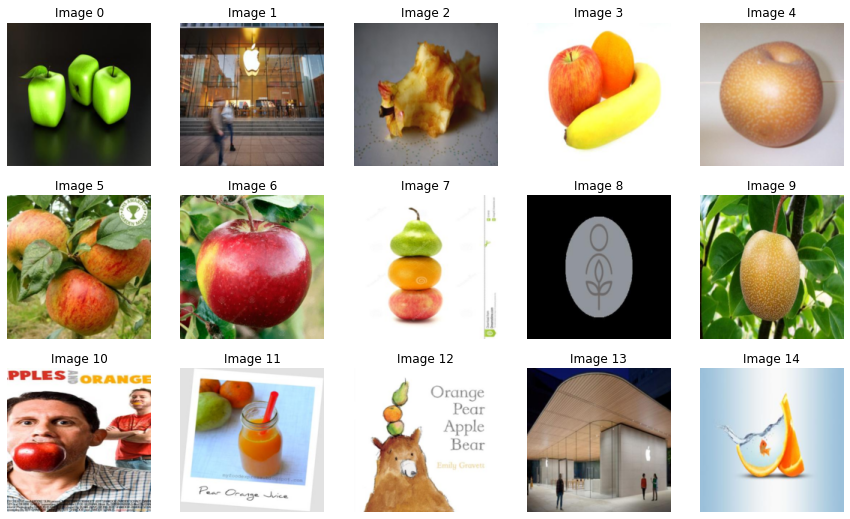

In [ ]:
interp.plot_top_losses(15, nrows=3)

It looks like our model is doing pretty good. The ones it missed are not correctly labelled or hard to figure out myself. We can test some images we downloaded in the beginning of this notebook

In [ ]:
is_fruit,_,probs = learn.predict(PILImage.create('apple.jpg'))
is_fruit

(#1) ['apple']

In [ ]:
is_fruit,_,probs = learn.predict(PILImage.create('random images.jpg'))
is_fruit, probs

((#1) ['random images'],
 TensorBase([2.0158e-03, 4.0127e-04, 5.0894e-04, 1.0000e+00]))

Looks good! We are ready to deploy it!

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]